In [1]:
import csv
import json
import random
import re
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

import torch

from datasets import (
    Dataset,
    DatasetDict,
    concatenate_datasets,
    load_dataset,
    load_from_disk,
)
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)

import evaluate

from nameparser import HumanName
from names_dataset import NameDataset, NameWrapper
from ethnicseer import EthnicClassifier
import nltk

import pycountry_convert as pc
import pycountry
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
ontonotes_id_to_label = {
    0: "O", 1: "B-CARDINAL", 2: "B-DATE", 3: "I-DATE", 4: "B-PERSON", 5: "I-PERSON",
    6: "B-NORP", 7: "B-GPE", 8: "I-GPE", 9: "B-LAW", 10: "I-LAW", 11: "B-ORG", 12: "I-ORG",
    13: "B-PERCENT", 14: "I-PERCENT", 15: "B-ORDINAL", 16: "B-MONEY", 17: "I-MONEY",
    18: "B-WORK_OF_ART", 19: "I-WORK_OF_ART", 20: "B-FAC", 21: "B-TIME", 22: "I-CARDINAL",
    23: "B-LOC", 24: "B-QUANTITY", 25: "I-QUANTITY", 26: "I-NORP", 27: "I-LOC",
    28: "B-PRODUCT", 29: "I-TIME", 30: "B-EVENT", 31: "I-EVENT", 32: "I-FAC",
    33: "B-LANGUAGE", 34: "I-PRODUCT", 35: "I-ORDINAL", 36: "I-LANGUAGE"
}

conll_label_to_id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
                     'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label = {v: k for k, v in conll_label_to_id.items()}

ontonotes_to_conll_entity = {
    "PERSON": "PER", "ORG": "ORG", "GPE": "LOC", "LOC": "LOC",
    "NORP": "MISC", "FAC": "MISC", "EVENT": "MISC", "WORK_OF_ART": "MISC",
    "LAW": "MISC", "PRODUCT": "MISC", "LANGUAGE": "MISC",
    "DATE": None, "TIME": None, "PERCENT": None, "MONEY": None,
    "QUANTITY": None, "ORDINAL": None, "CARDINAL": None
}

In [4]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_special_tokens_mask=True,
    )
    all_word_ids = []
    all_labels = []
    for i, labels in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        all_word_ids.append(word_ids)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    tokenized_inputs["word_ids"] = all_word_ids
    return tokenized_inputs

In [6]:
conll_encoded = load_from_disk("./splits/conll_encoded")
ontonotes_encoded = load_from_disk("./splits/ontonotes_encoded")

In [64]:
metric = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_predictions.append(
            [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100])
        true_labels.append([id2label[l] for l in label_seq if l != -100])

    return metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)

In [10]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [43]:
def process_data(data_list):

    def process_single(data):
        word_ids = data['word_ids']
        predictions = data['predictions']
        gold = data['gold']
        tokenized_tokens = data['tokens']

        word_ids = [a for a in word_ids if a is not None]
        predictions = [b for a, b in zip(
            word_ids, predictions) if a is not None]
        gold = [b for a, b in zip(word_ids, gold) if a is not None]

        processed_predictions = []
        processed_gold = []

        current_word_id = None
        current_predictions = []
        current_gold = []

        for idx, word_id in enumerate(word_ids):
            if word_id != current_word_id:
                if current_predictions:
                    processed_predictions.append(
                        Counter(current_predictions).most_common(1)[0][0])
                    processed_gold.append(
                        Counter(current_gold).most_common(1)[0][0])

                current_word_id = word_id
                current_predictions = [predictions[idx]]
                current_gold = [gold[idx]]
            else:
                current_predictions.append(predictions[idx])
                current_gold.append(gold[idx])

        if current_predictions:
            processed_predictions.append(
                Counter(current_predictions).most_common(1)[0][0])
            processed_gold.append(
                Counter(current_gold).most_common(1)[0][0])

        return processed_predictions, processed_gold

    processed_predictions_list = []
    processed_gold_list = []

    for data in data_list:
        processed_predictions, processed_gold = process_single(data)
        processed_predictions_list.append(processed_predictions)
        processed_gold_list.append(processed_gold)

    return processed_predictions_list, processed_gold_list


def evaluate_predictions(p, test_data):
    predictions, labels, _ = p

    pred_indices = [np.argmax(p, axis=-1) for p in predictions]
    label_indices = labels

    pred_tags = [[id2label[p] for p, l in zip(p_seq, l_seq) if l != -100]
                 for p_seq, l_seq in zip(pred_indices, label_indices)]
    gold_tags = [[id2label[l] for l in l_seq if l != -100]
                 for l_seq in label_indices]

    def add_preds(example, idx):
        length = len(example['word_ids'])
        example['predictions'] = pred_tags[idx][:length]
        example['gold'] = gold_tags[idx][:length]
        return example

    test_data = test_data.map(add_preds, with_indices=True)

    length = len(test_data['predictions'][0])

    pred, gold = process_data(test_data)

    flat_pred = [label for seq in pred for label in seq]
    flat_gold = [label for seq in gold for label in seq]

    print(classification_report(flat_gold, flat_pred, zero_division=0))

    return (pred, gold)

In [44]:
model = AutoModelForTokenClassification.from_pretrained("./saved_model/conll")
tokenizer = AutoTokenizer.from_pretrained(model_name)

conll_args = TrainingArguments(output_dir="./results/conll",
                               per_device_eval_batch_size=8, report_to="none")

conll_trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    args=conll_args,
)

C:\Users\NIKHIL\AppData\Local\Temp\ipykernel_17492\3354838511.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  conll_trainer = Trainer(


In [13]:
with open('./results/base_conll.pkl', 'rb') as f:
    base_conll = pickle.load(f)

In [45]:
x, y = evaluate_predictions(base_conll, ontonotes_encoded)

              precision    recall  f1-score   support

       B-LOC       0.82      0.89      0.85     17495
      B-MISC       0.63      0.70      0.66     10657
       B-ORG       0.62      0.64      0.63     13041
       B-PER       0.91      0.91      0.91     15547
       I-LOC       0.67      0.57      0.62      5367
      I-MISC       0.61      0.24      0.34      7305
       I-ORG       0.87      0.61      0.72     18313
       I-PER       0.94      0.87      0.90     11086
           O       0.98      0.99      0.99   1011383

    accuracy                           0.97   1110194
   macro avg       0.78      0.71      0.73   1110194
weighted avg       0.97      0.97      0.97   1110194



In [46]:
with open('./results/base_onto.pkl', 'rb') as f:
    base_onto = pickle.load(f)

In [47]:
x, y = evaluate_predictions(base_onto, conll_encoded)

              precision    recall  f1-score   support

       B-LOC       0.78      0.90      0.84      8535
      B-MISC       0.76      0.69      0.72      4062
       B-ORG       0.73      0.51      0.60      7398
       B-PER       0.91      0.93      0.92      7975
       I-LOC       0.60      0.77      0.67      1356
      I-MISC       0.43      0.68      0.53      1380
       I-ORG       0.62      0.75      0.68      4251
       I-PER       0.89      0.98      0.93      5503
           O       0.99      0.98      0.99    201398

    accuracy                           0.95    241858
   macro avg       0.75      0.80      0.76    241858
weighted avg       0.95      0.95      0.95    241858



In [21]:
stanford_encoded = load_from_disk("./splits/stanford_challenge_encoded")

In [22]:
with open('./results/base_stanford.pkl', 'rb') as f:
    base_stanford = pickle.load(f)

In [42]:
evaluate_predictions(base_stanford, stanford_encoded)
print()

              precision    recall  f1-score   support

       B-LOC       0.63      0.81      0.71       539
      B-MISC       0.94      0.92      0.93       319
       B-ORG       0.68      0.84      0.75      1214
       B-PER       0.87      0.61      0.72      1067
       I-LOC       0.78      0.87      0.82        79
      I-MISC       0.85      0.87      0.86        82
       I-ORG       0.79      0.91      0.84      2026
       I-PER       1.00      0.57      0.72       939
           O       0.99      0.99      0.99     22466

    accuracy                           0.94     28731
   macro avg       0.83      0.82      0.82     28731
weighted avg       0.95      0.94      0.94     28731




In [48]:
with open('./results/base_stanford_onto.pkl', 'rb') as f:
    base_stanford_onto = pickle.load(f)

In [49]:
x, y = evaluate_predictions(base_stanford_onto, stanford_encoded)

              precision    recall  f1-score   support

       B-LOC       0.61      0.81      0.70       539
      B-MISC       0.75      0.75      0.75       319
       B-ORG       0.43      0.43      0.43      1214
       B-PER       0.80      0.71      0.75      1067
       I-LOC       0.53      0.71      0.61        79
      I-MISC       0.40      0.70      0.51        82
       I-ORG       0.69      0.89      0.78      2026
       I-PER       0.95      0.69      0.80       939
           O       0.98      0.96      0.97     22466

    accuracy                           0.91     28731
   macro avg       0.68      0.74      0.70     28731
weighted avg       0.92      0.91      0.91     28731



In [51]:
nd = NameDataset()
country_codes = nd.get_country_codes()

continent_names = {
    'AF': 'Africa',
    'NA': 'North America',
    'OC': 'Oceania',
    'AN': 'Antarctica',
    'AS': 'Asia',
    'EU': 'Europe',
    'SA': 'South America',
}

continent_to_code = defaultdict(list)

continent_to_countries = defaultdict(list)

for code in country_codes:
    try:
        alpha_2 = code.alpha_2
        country = pycountry.countries.get(alpha_2=alpha_2)
        if not country:
            continue

        continent_code = pc.country_alpha2_to_continent_code(alpha_2)
        continent = continent_names[continent_code]

        continent_to_code[continent].append(alpha_2)
        continent_to_countries[continent].append((alpha_2, country.name))

    except Exception as e:
        print(f"Skipping {code} due to error: {e}")
        continue

In [52]:
def get_names(country, n=10):
    names_dict = nd.get_top_names(n=n, country_alpha2=country)
    names = []
    if country in names_dict:
        country_names = names_dict[country]
        for gender in ['M', 'F']:
            if gender in country_names:
                names.extend(country_names[gender])
    return list(set(names))


def tokenize(text):
    tokens = re.findall(r"\w+|[^\w\s]", text, re.UNICODE)
    return tokens


def tag_tokens(tokens, person_names):
    tags = ["O"] * len(tokens)
    for name in person_names:
        name_tokens = name.split()
        n_len = len(name_tokens)
        for i in range(len(tokens) - n_len + 1):
            if tokens[i:i + n_len] == name_tokens:
                tags[i] = "B-PER"
                for j in range(i + 1, i + n_len):
                    tags[j] = "I-PER"
    return tags


def generate_challenge_dataset(num_samples=300):
    dataset = []

    for _ in range(num_samples):
        country = random.choice(chosen_countries)
        names = get_names(country, n=10)
        if not names:
            continue

        if len(names) == 1:
            name1 = names[0]
            name2 = None
        else:
            name1, name2 = random.sample(names, 2)

        template = random.choice(sentence_templates)

        if "{name2}" in template and name2 is None:
            sentence = template.format(name=name1, name2=name1)
            person_names = [name1]
        elif "{name2}" in template:
            sentence = template.format(name=name1, name2=name2)
            person_names = [name1, name2]
        else:
            sentence = template.format(name=name1)
            person_names = [name1]

        tokens = tokenize(sentence)
        tags = tag_tokens(tokens, person_names)

        dataset.append(list(zip(tokens, tags)))

    return dataset


def save_to_csv(dataset, filepath="non_western_ner_challenge.csv"):
    with open(filepath, mode="w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["sentence_id", "token", "tag"])
        for idx, sentence in enumerate(dataset):
            for token, tag in sentence:
                writer.writerow([idx, token, tag])

In [53]:
name_data = []


def evaluate_csv(file):
    print('evaluating', file)
    scripted_challenge = pd.read_csv(file)

    examples = []
    for sentence_id, group in scripted_challenge.groupby("sentence_id"):
        tokens = group["token"].tolist()
        tags = group["tag"].tolist()
        examples.append({"tokens": tokens, "ner_tags": tags})

    unique_tags = sorted(set(tag for ex in examples for tag in ex["ner_tags"]))

    for ex in examples:
        ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

    challenge_dataset = Dataset.from_list(examples)
    tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)

    a = conll_trainer.predict(tokenized)

    with open(f'./results/challenge_{file[:-3]}.pkl', 'wb') as f:
        pickle.dump(a, f)

    x, y = evaluate_predictions(a, tokenized)
    print()
    print('-'*30)

    # a['eval_PER']['name'] = file
    # name_data.append(a['eval_PER'])
    # print(a['eval_PER'])
    # print()

In [55]:
for x in list(continent_to_code.keys()):
    evaluate_csv(x+'_ner_challenge.csv')

evaluating Asia_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
      B-MISC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.98      0.93      0.96      1134
       I-LOC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
       I-PER       1.00      1.00      1.00         6
           O       1.00      0.98      0.99      9744

    accuracy                           0.97     10884
   macro avg       0.37      0.36      0.37     10884
weighted avg       1.00      0.97      0.98     10884


------------------------------
evaluating North America_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.98      0.95      0.97      1145
       I-LOC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
       I-PER       1.00      1.00      1.00        75
           O       1.00      0.98      0.99      9569

    accuracy                           0.97     10789
   macro avg       0.43      0.42      0.42     10789
weighted avg       1.00      0.97      0.99     10789


------------------------------
evaluating Europe_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.98      0.96      0.97      1136
       I-LOC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
           O       1.00      0.98      0.99      9682

    accuracy                           0.98     10818
   macro avg       0.33      0.32      0.33     10818
weighted avg       1.00      0.98      0.99     10818


------------------------------
evaluating South America_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.98      0.98      0.98      1164
       I-LOC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
       I-PER       1.00      1.00      1.00         2
           O       1.00      0.98      0.99      9624

    accuracy                           0.98     10790
   macro avg       0.43      0.42      0.42     10790
weighted avg       1.00      0.98      0.99     10790


------------------------------
evaluating Africa_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.97      0.94      0.96      1163
       I-LOC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
       I-PER       1.00      1.00      1.00         9
           O       1.00      0.98      0.99      9682

    accuracy                           0.98     10854
   macro avg       0.42      0.42      0.42     10854
weighted avg       1.00      0.98      0.99     10854


------------------------------
evaluating Oceania_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.98      0.86      0.92      1148
       I-LOC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
           O       1.00      0.98      0.99      9548

    accuracy                           0.97     10696
   macro avg       0.33      0.31      0.32     10696
weighted avg       1.00      0.97      0.98     10696


------------------------------


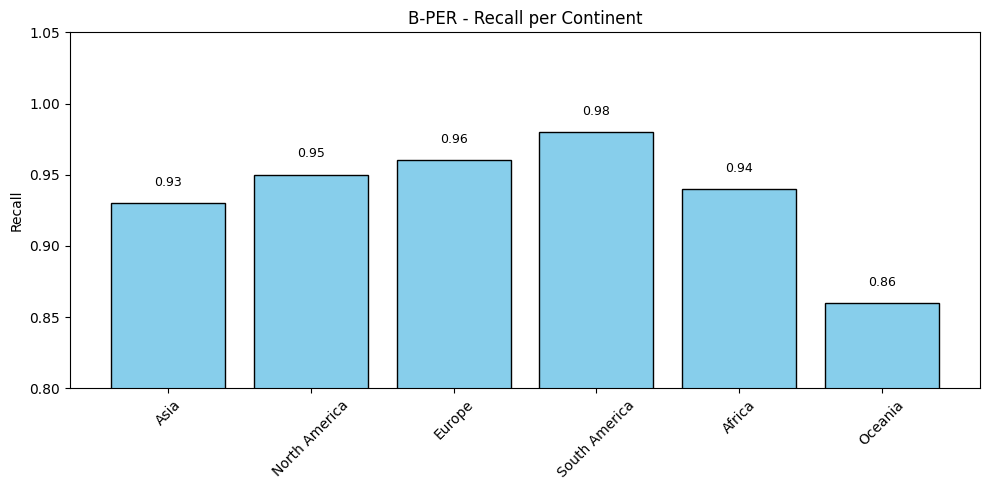

In [61]:
import matplotlib.pyplot as plt

# B-PER metrics per continent
b_per_metrics = {
    'Asia':     {'precision': 0.98, 'recall': 0.93, 'f1': 0.96},
    'North America': {'precision': 0.98, 'recall': 0.95, 'f1': 0.97},
    'Europe':   {'precision': 0.98, 'recall': 0.96, 'f1': 0.97},
    'South America': {'precision': 0.98, 'recall': 0.98, 'f1': 0.98},
    'Africa':   {'precision': 0.97, 'recall': 0.94, 'f1': 0.96},
    'Oceania':  {'precision': 0.98, 'recall': 0.86, 'f1': 0.92}
}

# I-PER metrics per continent
i_per_metrics = {
    'Asia':     {'precision': 1.00, 'recall': 1.00, 'f1': 1.00},
    'North America': {'precision': 1.00, 'recall': 1.00, 'f1': 1.00},
    'Europe':   {'precision': None, 'recall': None, 'f1': None},  # No support
    'South America': {'precision': 1.00, 'recall': 1.00, 'f1': 1.00},
    'Africa':   {'precision': 1.00, 'recall': 1.00, 'f1': 1.00},
    'Oceania':  {'precision': None, 'recall': None, 'f1': None}   # No support
}


def plot_metric(data, label, metric):
    continents = list(data.keys())
    values = [data[continent][metric] if data[continent]
              [metric] is not None else 0 for continent in continents]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(continents, values, color='skyblue', edgecolor='black')
    plt.ylim(0.8, 1.05)
    plt.title(f'{label} - {metric.capitalize()} per Continent')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)

    # Label bars with values
    for bar, val in zip(bars, values):
        label = f'{val:.2f}' if val is not None else 'N/A'
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, label,
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


# B-PER plots
# plot_metric(b_per_metrics, label='B-PER', metric='precision')
plot_metric(b_per_metrics, label='B-PER', metric='recall')
# plot_metric(b_per_metrics, label='B-PER', metric='f1')

In [103]:
def evaluate_csv_error(file):
    print('evaluating', file)
    scripted_challenge = pd.read_csv(file)

    examples = []
    for sentence_id, group in scripted_challenge.groupby("sentence_id"):
        tokens = group["token"].tolist()
        tags = group["tag"].tolist()
        examples.append({"tokens": tokens, "ner_tags": tags})

    for ex in examples:
        ex["labels"] = [conll_label_to_id[tag] for tag in ex["ner_tags"]]

    challenge_dataset = Dataset.from_list(examples)
    tokenized = challenge_dataset.map(tokenize_and_align_labels, batched=True)

    # Get model predictions
    outputs = conll_trainer.predict(tokenized)

    predictions, true_labels = evaluate_predictions(outputs, tokenized)

    flat_pred = [label for seq in predictions for label in seq]
    flat_gold = [label for seq in true_labels for label in seq]
    cm = confusion_matrix(flat_gold, flat_pred)
    all_labels = sorted(set(flat_gold) | set(flat_pred))
    for i in range(len(all_labels)):
        cm[i][i] = 0

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=all_labels)
    disp.plot()
    plt.show()

    # Error analysis
    for i, example in enumerate(examples):
        tokens = example['tokens']
        expected_tags = example['ner_tags']
        predicted_ids = predictions[i]
        true_ids = true_labels[i]

        # for token, expected, predicted in zip(tokens, expected_tags, predicted_ids):
        #     if expected != predicted:
        #         if expected == 'B-PER' and predicted == 'B-ORG':
        #             print(f"Word: {token}")
        #             print(f"Expected tag: {expected}")
        #             print(f"Predicted tag: {predicted}")
        #             print(f"Full sentence: {' '.join(tokens)}")
        #             print("------")

evaluating Oceania_ner_challenge.csv


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.98      0.86      0.92      1148
       I-LOC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
           O       1.00      0.98      0.99      9548

    accuracy                           0.97     10696
   macro avg       0.33      0.31      0.32     10696
weighted avg       1.00      0.97      0.98     10696



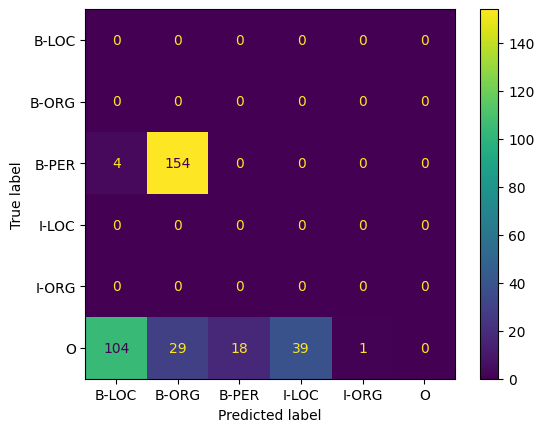

Word: Litia
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: It was Litia who finalized the agreement .
------
Word: Melaia
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: The final report was prepared by Melaia .
------
Word: Litia
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: Litia introduced Seru as the lead consultant on the project .
------
Word: Siteri
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: Siteri introduced Inoke as the lead consultant on the project .
------
Word: Joseva
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: The final report was prepared by Joseva .
------
Word: Rusiate
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: Rusiate introduced Akanisi as the lead consultant on the project .
------
Word: Joseva
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: The final report was prepared by Joseva .
------
Word: Tevita
Expected tag: B-PER
Predicted tag: B-ORG
Full sentence: The final report was prepared by Tevit

In [104]:
evaluate_csv_error('Oceania_ner_challenge.csv')